In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import bilby
import ptemcee

from toy import (
    SimpleGaussianLikelihood, GeneralizedNormalLikelihood, sample_generalized_gaussian,
    alpha_to_sigma, sigma_to_alpha,
    temper_posterior_weights, plot_tempered_posterior_weights, generate_ptemcee_pos0,
    plot_posterior_predictive_distribution
)

from util import HYBRID_COLOR, COMP_COLOR, HYBRID_EVOL_COLORS

plt.style.use("./tgr-hybrid-sampling.mplstyle")

%load_ext autoreload
%autoreload 2

# Well-specified Model

In [5]:
N = 10000
mu_true = 3
alpha_true = 5
beta_true = 2

data = sample_generalized_gaussian(mu_true, alpha_true, beta_true, N)

## First Step - Dynesty

In [3]:
label = "wellspecified_dynesty-step"
outdir = "./wellspecified/wellspecified_dynesty-step" 

gaussian_likelihood = SimpleGaussianLikelihood(data)
priors = dict(
    mu=bilby.core.prior.Uniform(0, 5, 'mu'),
    sigma=bilby.core.prior.Uniform(0, 10, 'sigma'),
)

nlive = 500

# And run sampler
result_hybrid_nest = bilby.run_sampler(
    likelihood=gaussian_likelihood, priors=priors, sampler='dynesty', npoints=nlive,
    walks=10, outdir=outdir, label=label)

08:22 bilby INFO    : Running for label 'wellspecified_dynesty-step', output will be saved to './wellspecified/wellspecified_dynesty-step'
08:22 bilby INFO    : Search parameters:
08:22 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name='mu', latex_label='mu', unit=None, boundary=None)
08:22 bilby INFO    :   sigma = Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
08:22 bilby INFO    : Single likelihood evaluation took 7.538e-05 s


0it [00:00, ?it/s]

08:22 bilby INFO    : Checkpoint every check_point_delta_t = 600s
08:22 bilby WARNING : Using cached result
08:22 bilby INFO    : Summary of results:
nsamples: 6215
ln_noise_evidence:    nan
ln_evidence: -26914.266 +/-  0.180
ln_bayes_factor:    nan +/-  0.180



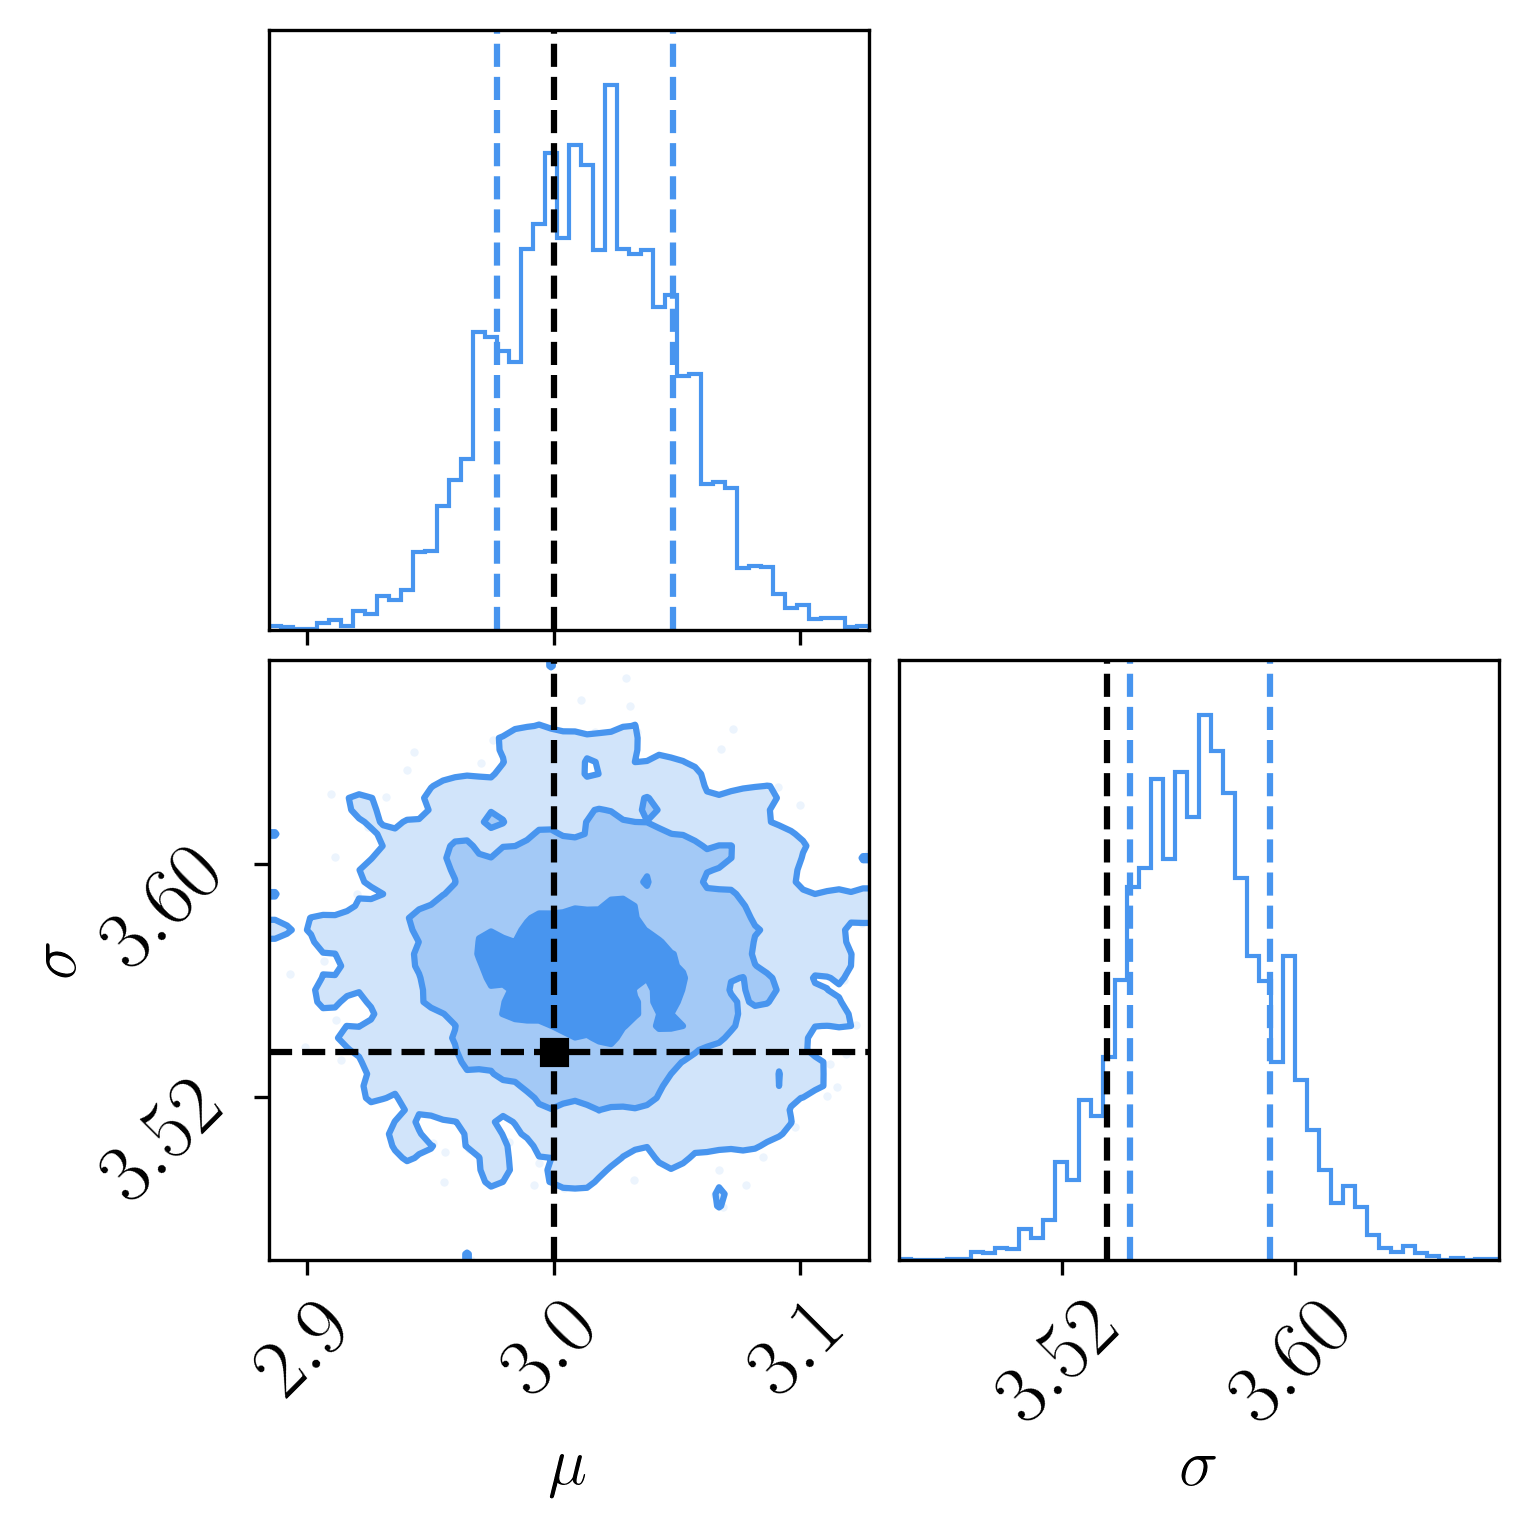

In [4]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_nest.plot_corner(
        parameters=dict(
            mu=mu_true,
            sigma=alpha_to_sigma(alpha_true)
        ),
        titles=False,
        labels=[r"$\mu$", r"$\sigma$"],
        color=COMP_COLOR,
        truth_color="black",
        dpi=80
    )

fig

## Second Step - ptemcee

### Setup Tempered Initial Points

In [5]:
label_pt = "wellspecified_ptemcee-step"
outdir_pt = "./wellspecified/wellspecified_ptemcee-step"

ndims    = 3   # 3 dimensions i.e. parameters, {mu, alpha, beta}
nwalkers = 200 # number of walkers in our ensemble
ntemps   = 7   # number of temperatures in our ensemble

# generate the temperatures in our ensemble
beta_T = ptemcee.default_beta_ladder(
    ndim=ndims,            
    ntemps=ntemps,
    Tmax=None
)

In [6]:
nested_samples = result_hybrid_nest.nested_samples

tempered_posterior_weights = temper_posterior_weights(
    nlive = nlive, 
    log_likelihood = nested_samples["log_likelihood"].values, 
    beta_T = beta_T
)

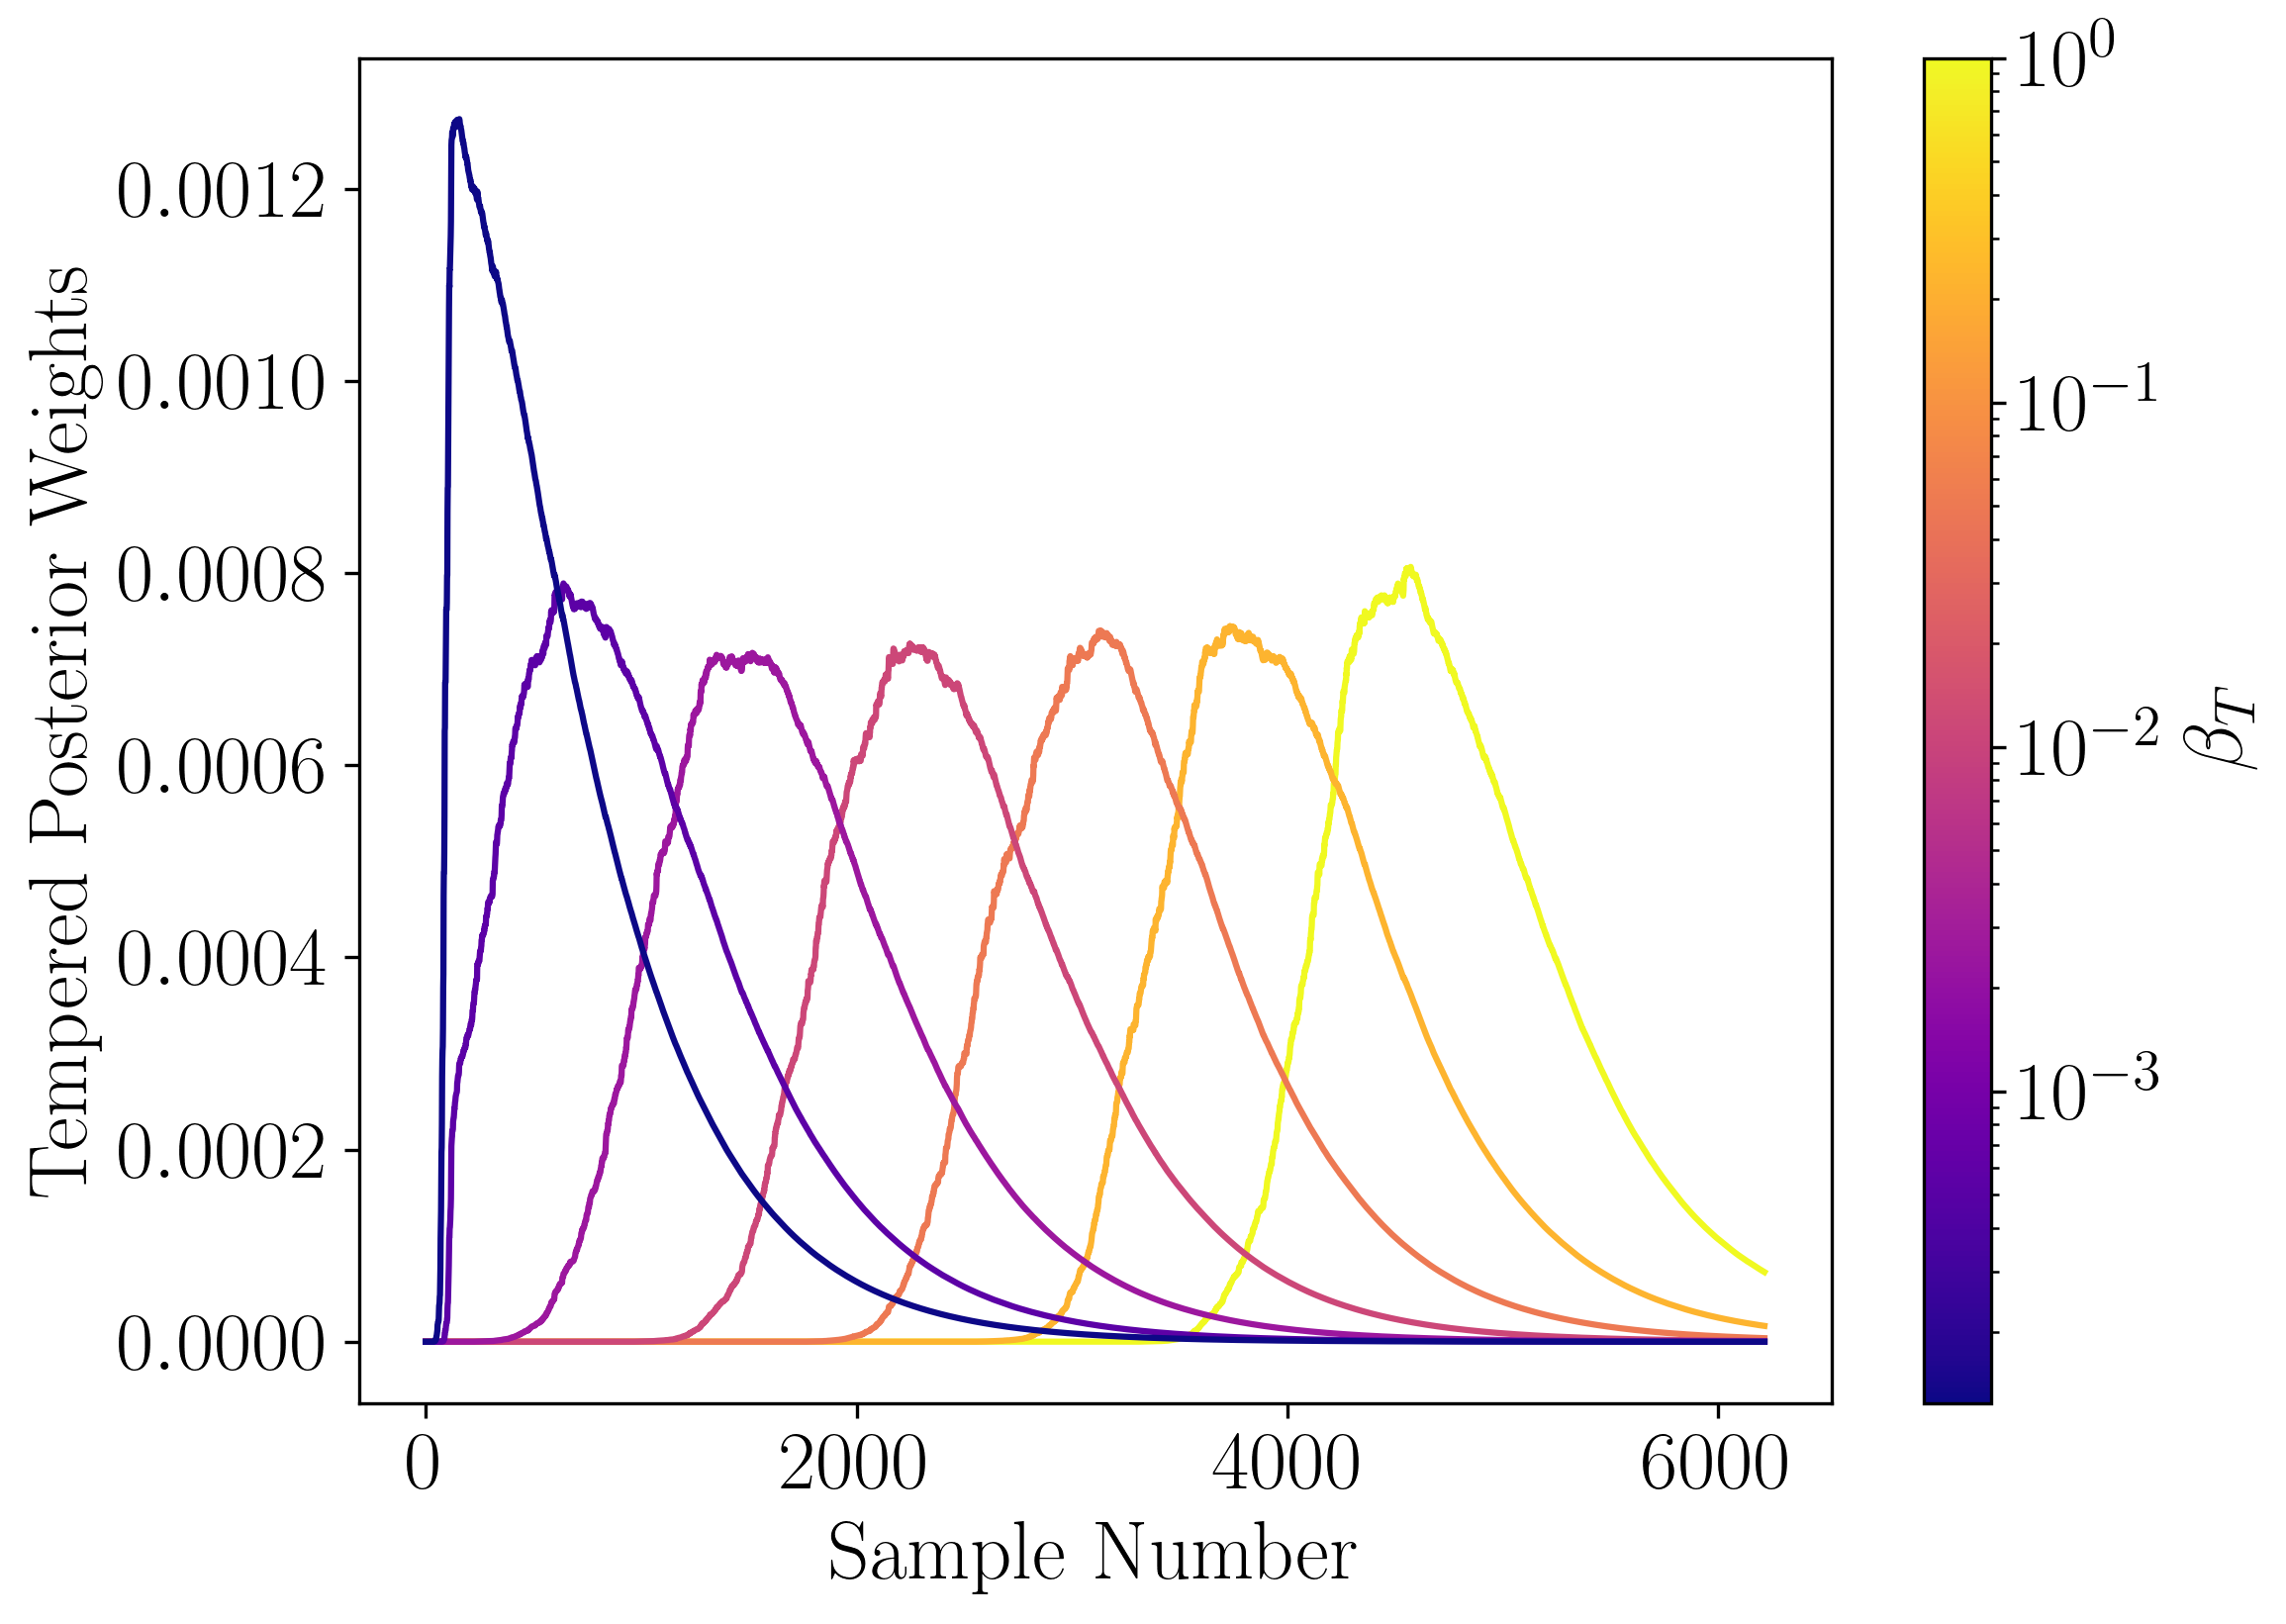

In [7]:
with plt.rc_context({'figure.figsize' : (8, 6)}):
    plot_tempered_posterior_weights(
        beta_T = beta_T,
        tempered_posterior_weights = tempered_posterior_weights
)

In [8]:
pos0 = generate_ptemcee_pos0(
    ntemps = ntemps,
    nwalkers = nwalkers,
    ndims = ndims,
    tempered_posterior_weights = tempered_posterior_weights,
    nested_samples = nested_samples
)

In [9]:
generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)

priors_pt = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

result_hybrid_pt = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, 
    pos0     = pos0, 
    priors   = priors_pt, 
    outdir   = outdir_pt,
    ntemps   = ntemps,
    betas    = beta_T,
    nwalkers = nwalkers,
    label    = label_pt, 
    sampler  = 'ptemcee',
    npool = 4
)

08:22 bilby INFO    : Running for label 'wellspecified_ptemcee-step', output will be saved to './wellspecified/wellspecified_ptemcee-step'
08:22 bilby INFO    : Search parameters:
08:22 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
08:22 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
08:22 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
08:22 bilby INFO    : Single likelihood evaluation took 4.640e-04 s
08:22 bilby WARNING : Supplied argument 'npool' not an argument of 'Ptemcee', removing.
08:22 bilby INFO    : Using convergence inputs: ConvergenceInputs(autocorr_c=5, autocorr_tol=50, autocorr_tau=1, gradient_tau=0.1, gradient_mean_log_posterior=0.1, Q_tol=1.02, safety=1, burn_in_nact=50, burn_in_fixed_discard=0, mean_logl_frac=0.01, thin_by_nact=0.5, nsamples=5000, 

0it [00:06, ?it/s]


08:22 bilby INFO    : Summary of results:
nsamples: 22000
ln_noise_evidence:    nan
ln_evidence: -26918.972 +/- 19.747
ln_bayes_factor:    nan +/- 19.747



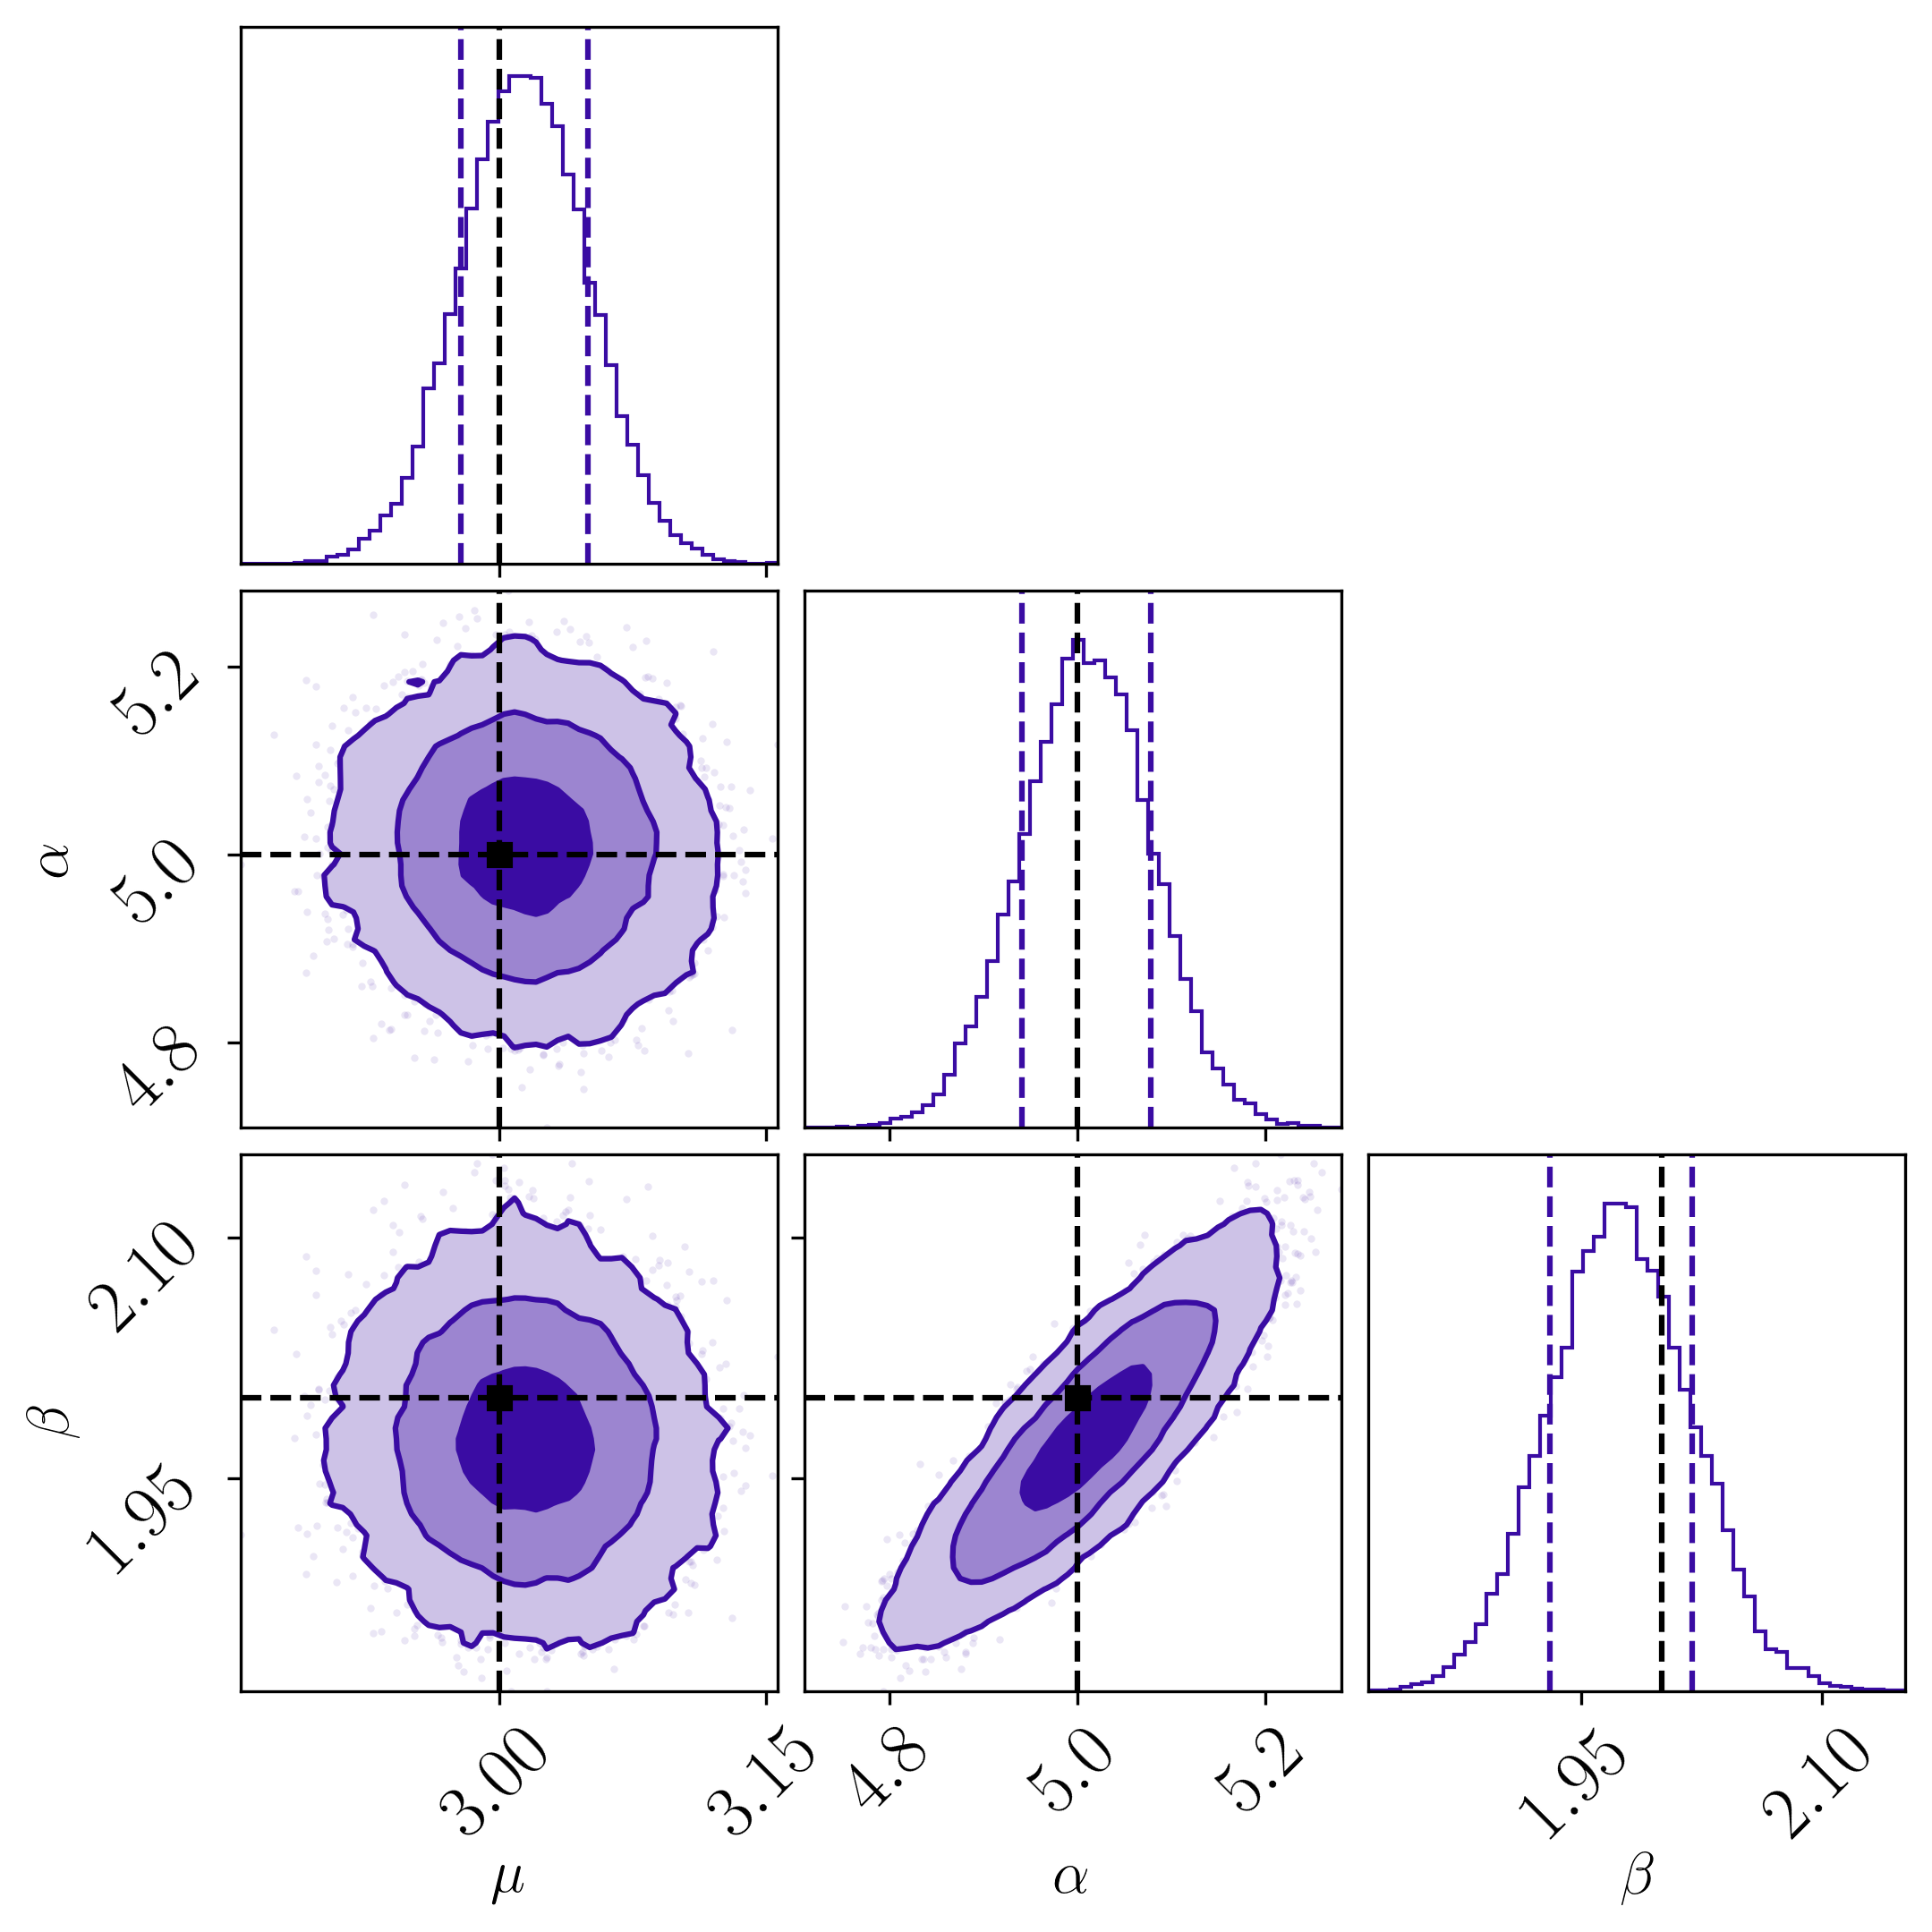

In [10]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_pt.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        color=HYBRID_COLOR,
        truth_color="black"
    )

fig

## With Dynesty Only

In [11]:
label_nest_only = "wellspecified_dynesty-only"
outdir_nest_only = "./wellspecified/wellspecified_dynesty-only" 

generalized_gaussian_likelihood = GeneralizedNormalLikelihood(data)
priors_nest_only = dict(
    mu=bilby.core.prior.Uniform(minimum=0,maximum=5, latex_label=r"$\mu$"),
    alpha=bilby.core.prior.Uniform(minimum=0,maximum=10 * np.sqrt(2), latex_label=r"$\alpha$"),
    beta=bilby.core.prior.Uniform(minimum=0,maximum=10, latex_label=r"$\beta$")
)

nlive = 500

# And run sampler
result_hybrid_nest_only = bilby.run_sampler(
    likelihood=generalized_gaussian_likelihood, priors=priors_nest_only, sampler='dynesty', npoints=nlive,
    walks=10, outdir=outdir_nest_only, label=label_nest_only)

08:22 bilby INFO    : Running for label 'wellspecified_dynesty-only', output will be saved to './wellspecified/wellspecified_dynesty-only'
08:22 bilby INFO    : Search parameters:
08:22 bilby INFO    :   mu = Uniform(minimum=0, maximum=5, name=None, latex_label='$\\mu$', unit=None, boundary=None)
08:22 bilby INFO    :   alpha = Uniform(minimum=0, maximum=14.142135623730951, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
08:22 bilby INFO    :   beta = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\beta$', unit=None, boundary=None)
08:22 bilby INFO    : Single likelihood evaluation took 5.014e-04 s


0it [00:00, ?it/s]

08:22 bilby INFO    : Checkpoint every check_point_delta_t = 600s
08:22 bilby WARNING : Using cached result
08:22 bilby INFO    : Summary of results:
nsamples: 8506
ln_noise_evidence:    nan
ln_evidence: -26918.680 +/-  1.317
ln_bayes_factor:    nan +/-  1.317



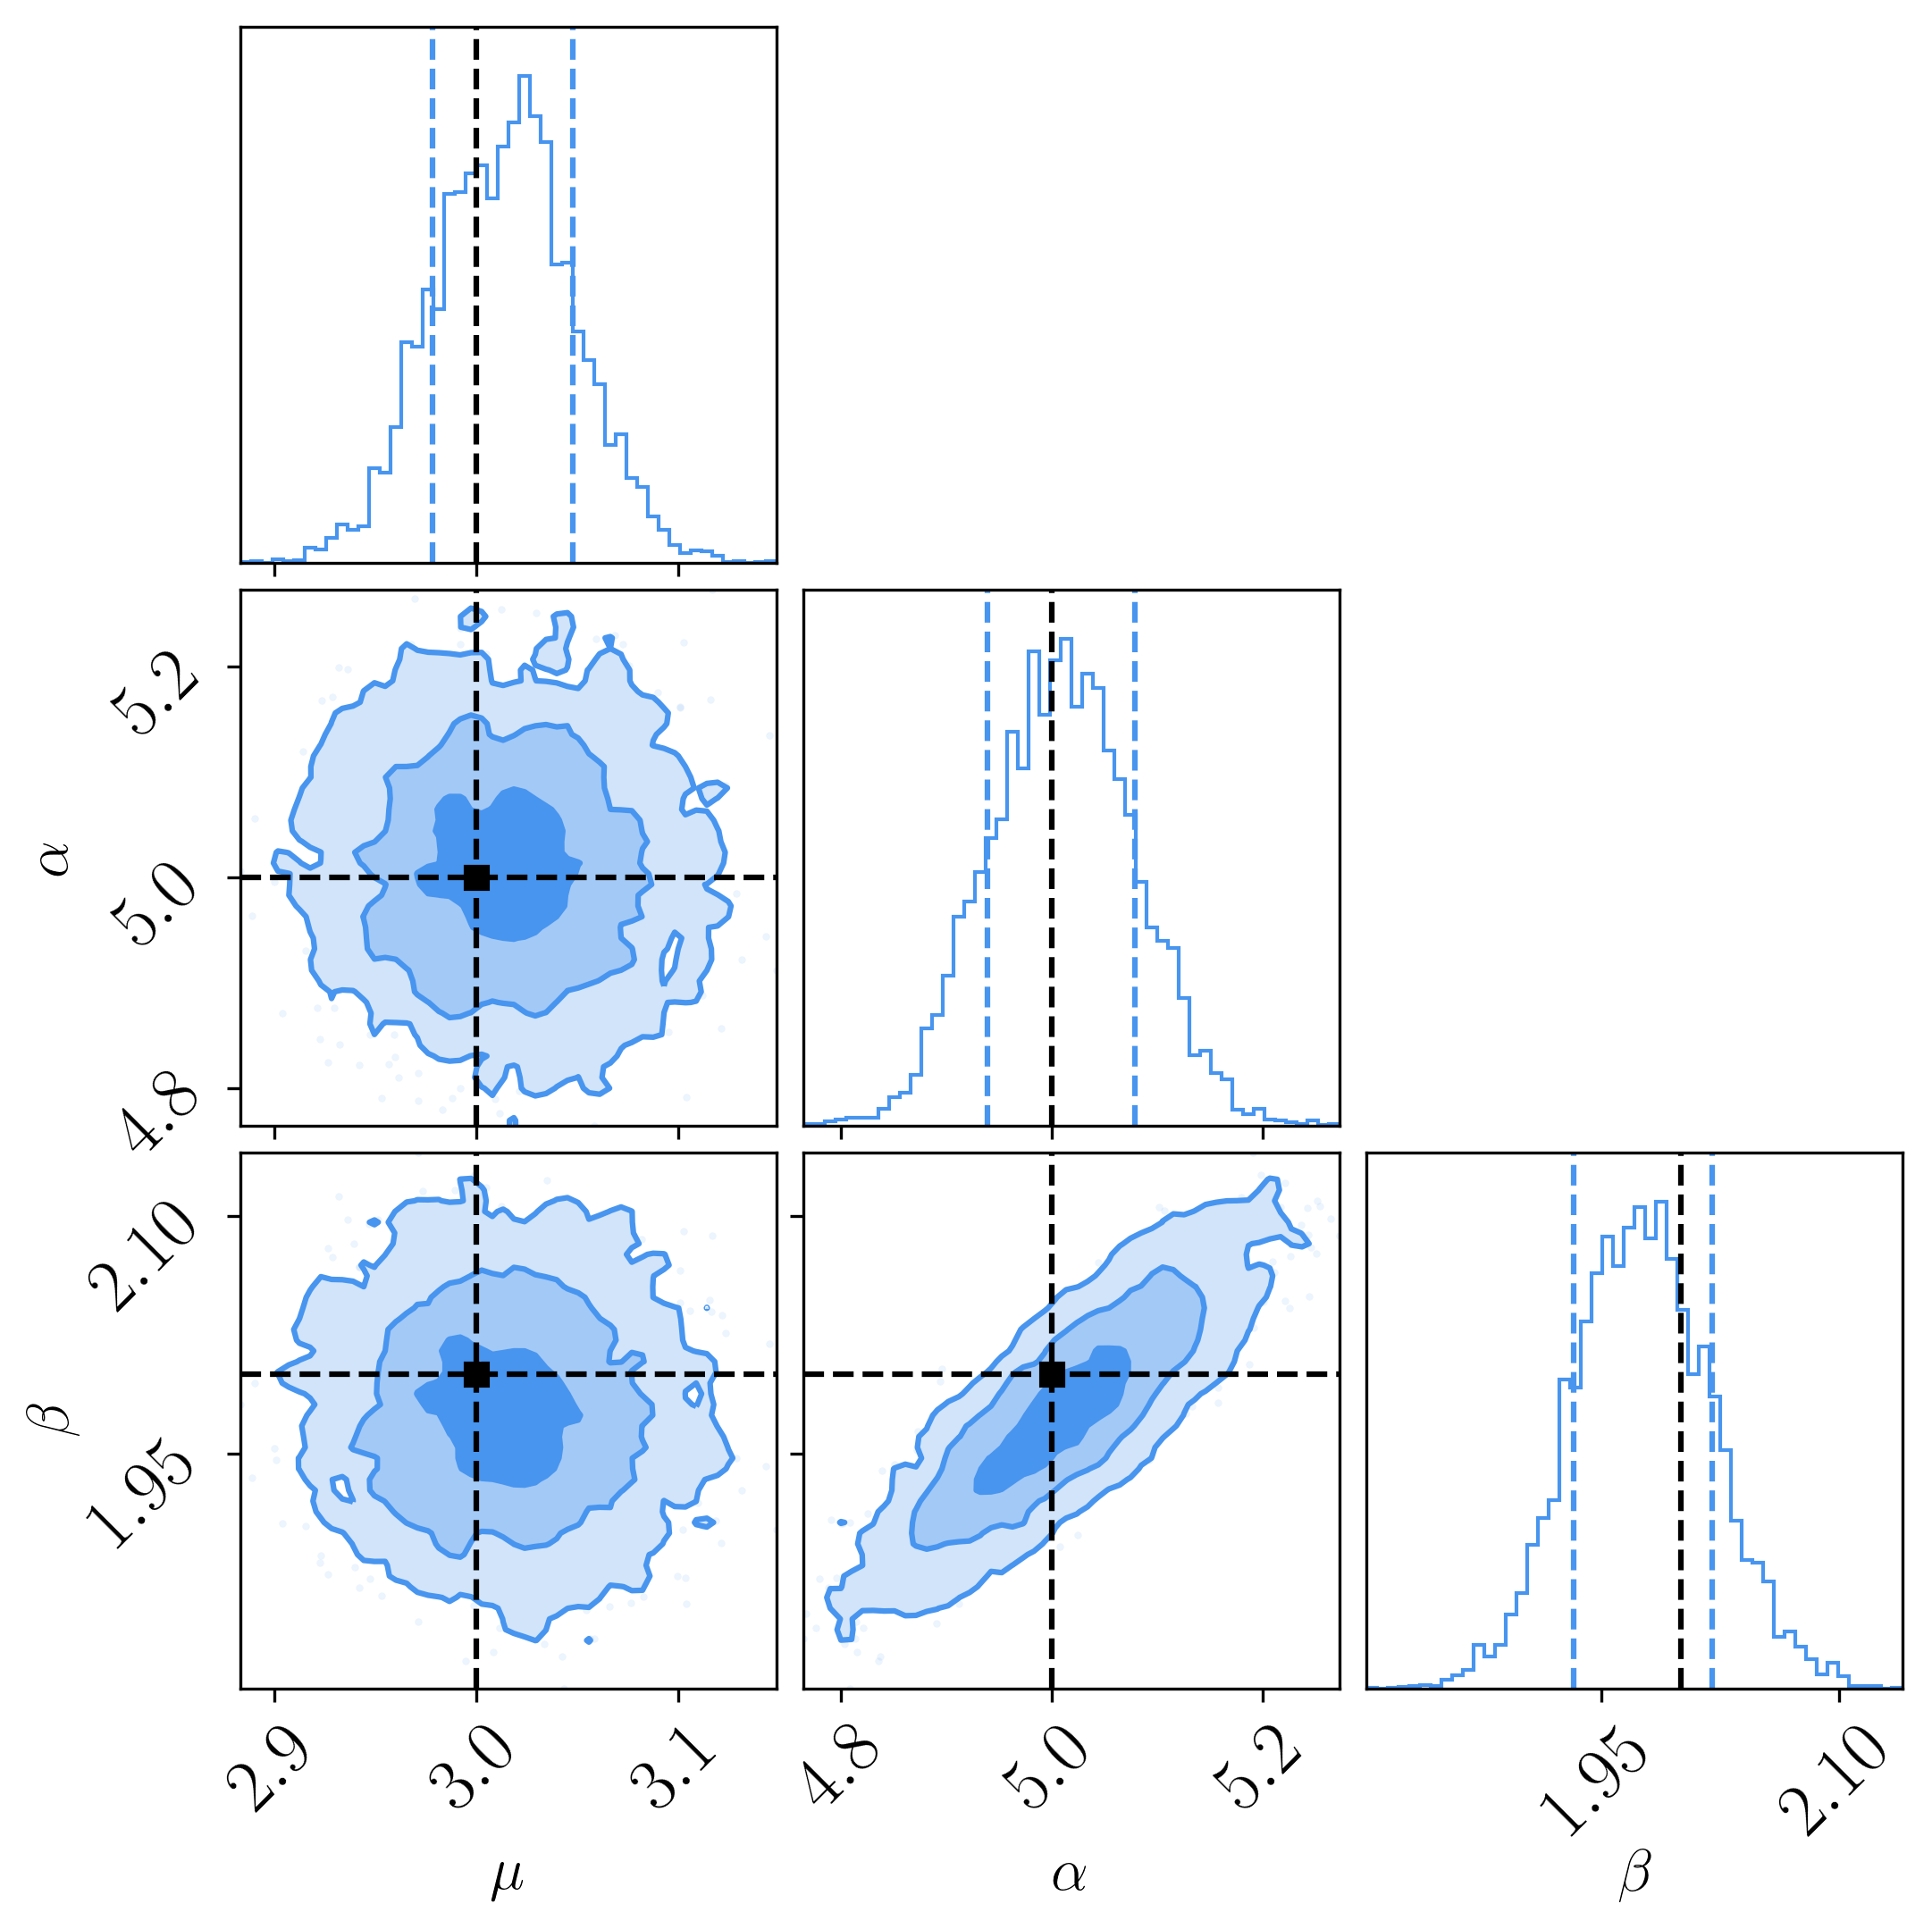

In [12]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = result_hybrid_nest_only.plot_corner(
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        titles=False,
        labels=[r"$\mu$", r"$\alpha$", r"$\beta$"],
        color=COMP_COLOR,
        truth_color="black"
    )

fig

# Comparison

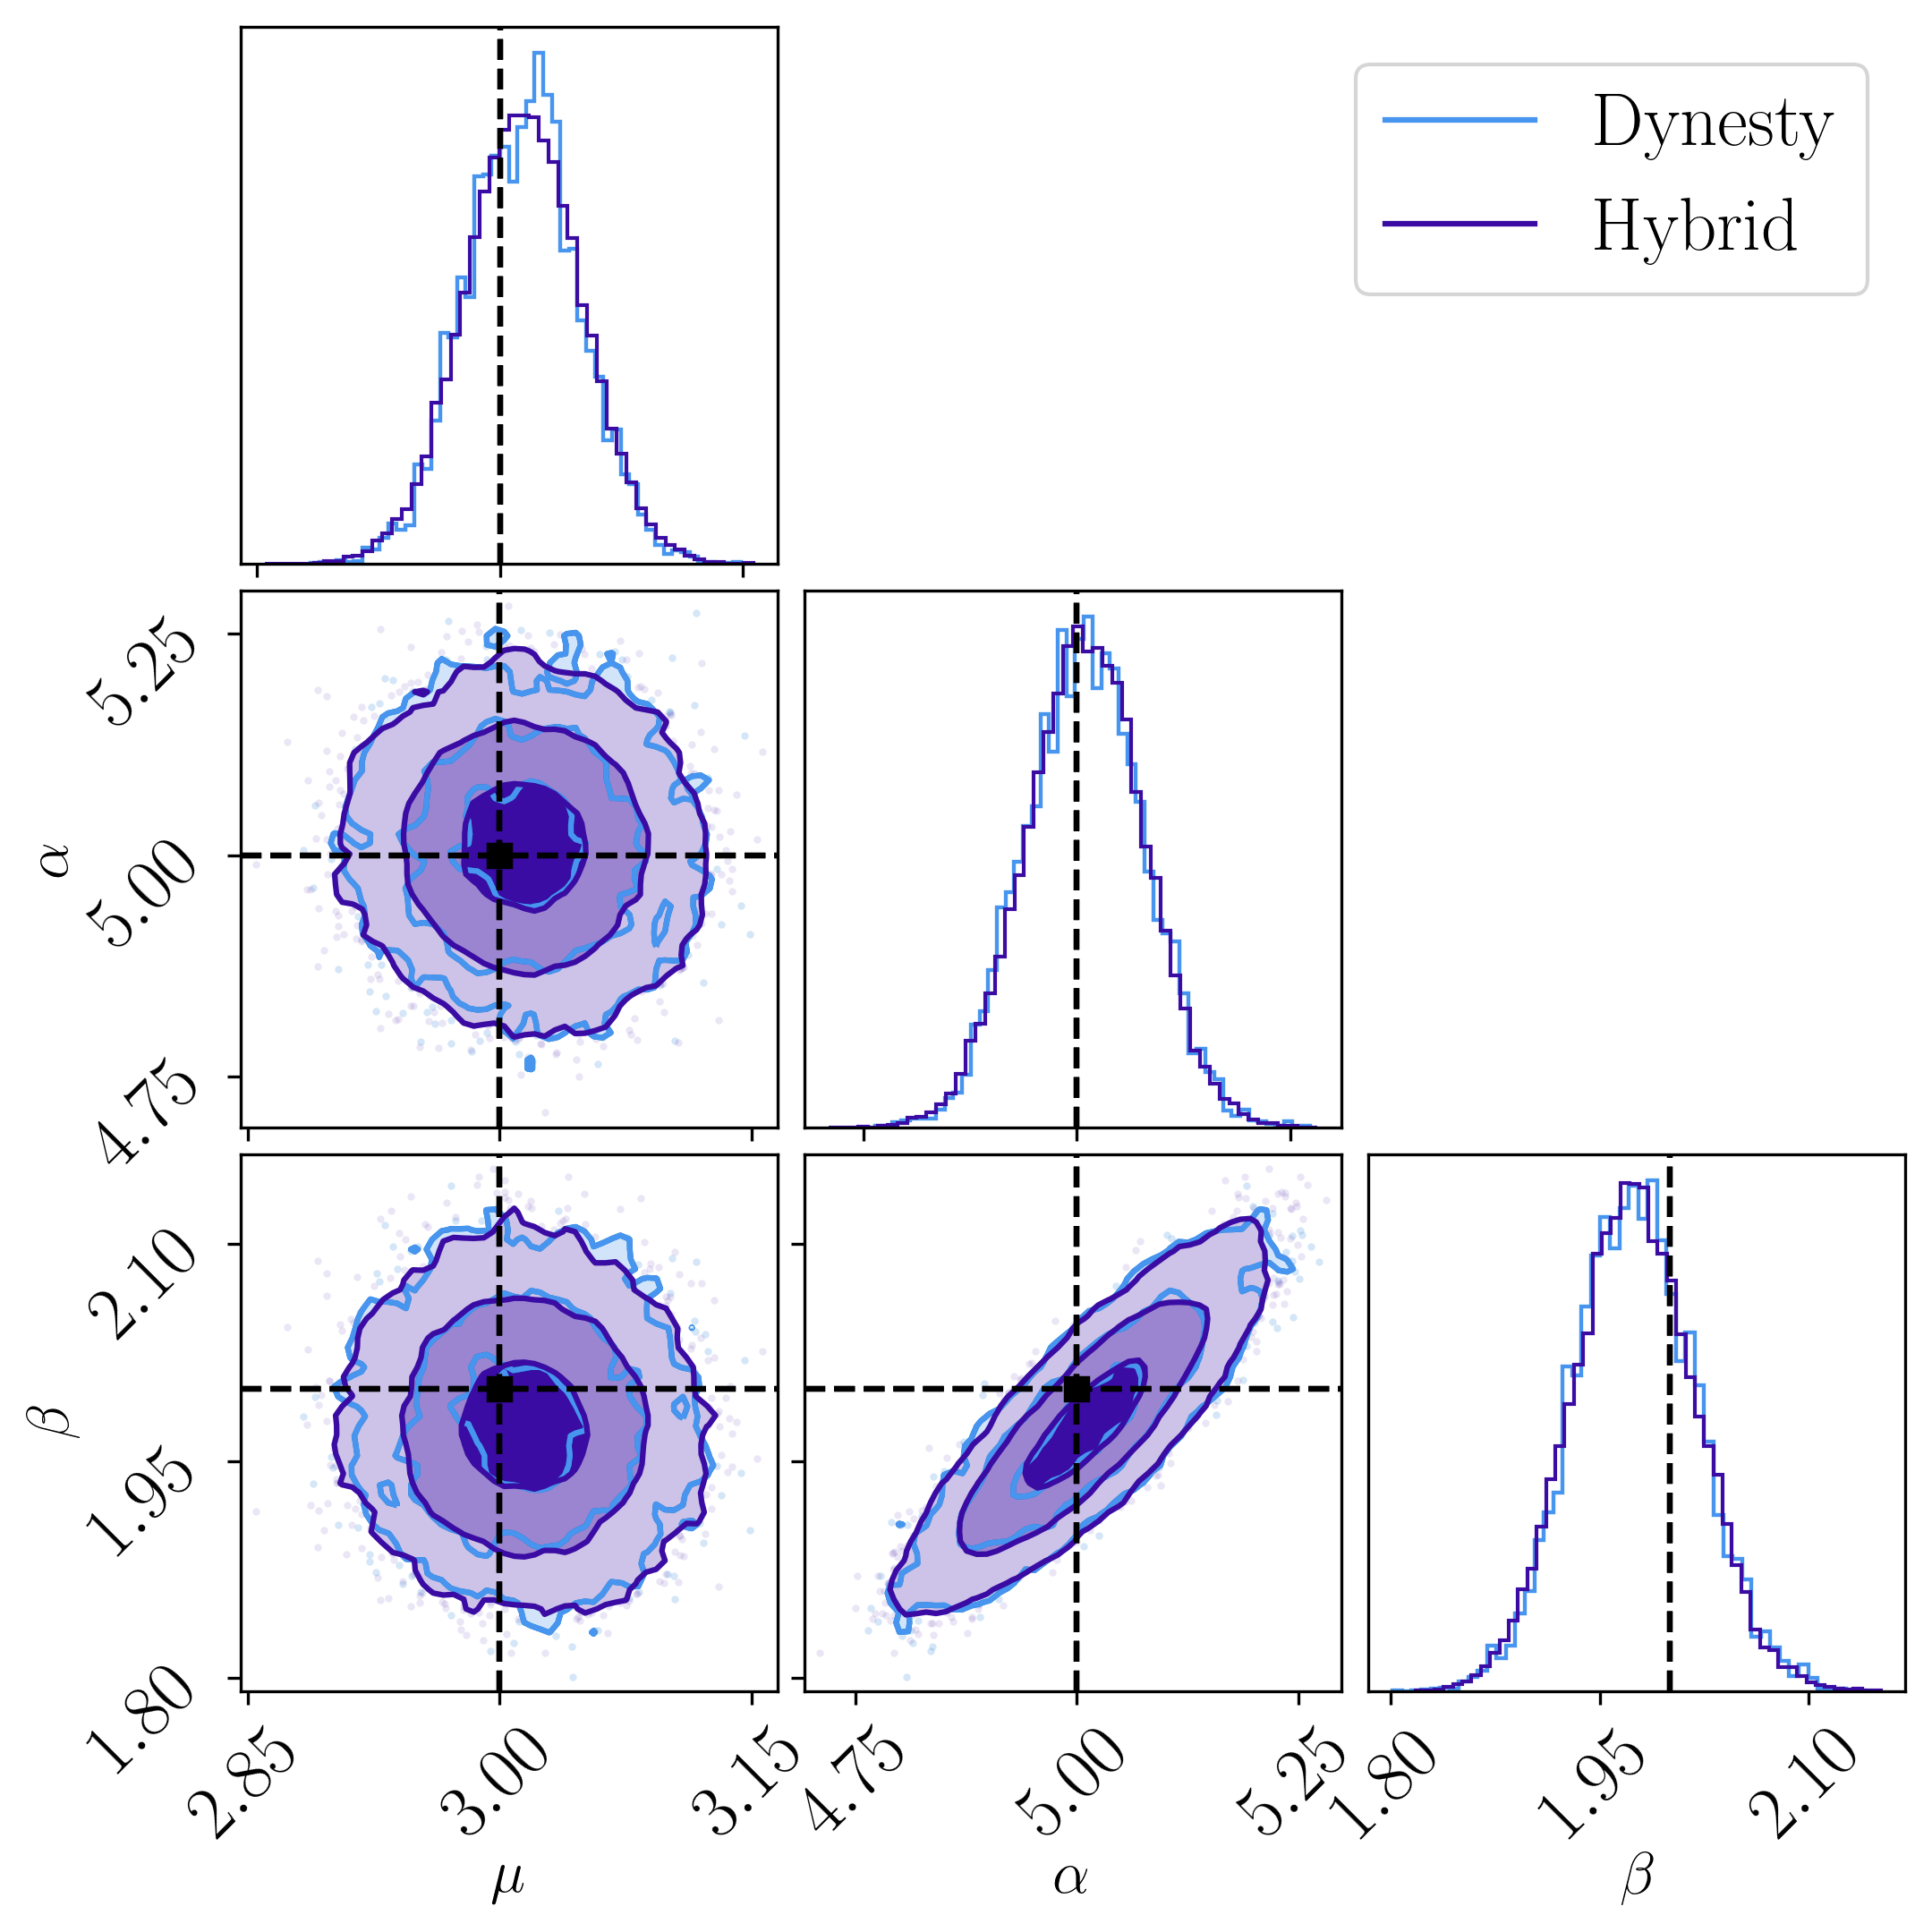

In [13]:
## Combined Corner plot of dynesty-only, hybrid results
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = bilby.core.result.plot_multiple(
        [result_hybrid_nest_only, result_hybrid_pt],
        labels=["Dynesty", "Hybrid"],
        colours=[COMP_COLOR, HYBRID_COLOR],
        titles=False,
        truth_color="black",
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        quantiles = None
    )

axes = fig.get_axes()
axes[2].legend(
    [ mpl.lines.Line2D([], [], color=COMP_COLOR), mpl.lines.Line2D([], [], color=HYBRID_COLOR) ],
    [ "Dynesty", "Hybrid" ]
)



fig.savefig("./toy-model_wellspecified_comparison.pdf", bbox_inches="tight")

# Rename Beta -> Gamma

In [2]:
result_hybrid_nest_only = bilby.core.result.read_in_result("./wellspecified/wellspecified_dynesty-only/wellspecified_dynesty-only_result.json")
result_hybrid_pt = bilby.core.result.read_in_result("./wellspecified/wellspecified_ptemcee-step/wellspecified_ptemcee-step_result.json")

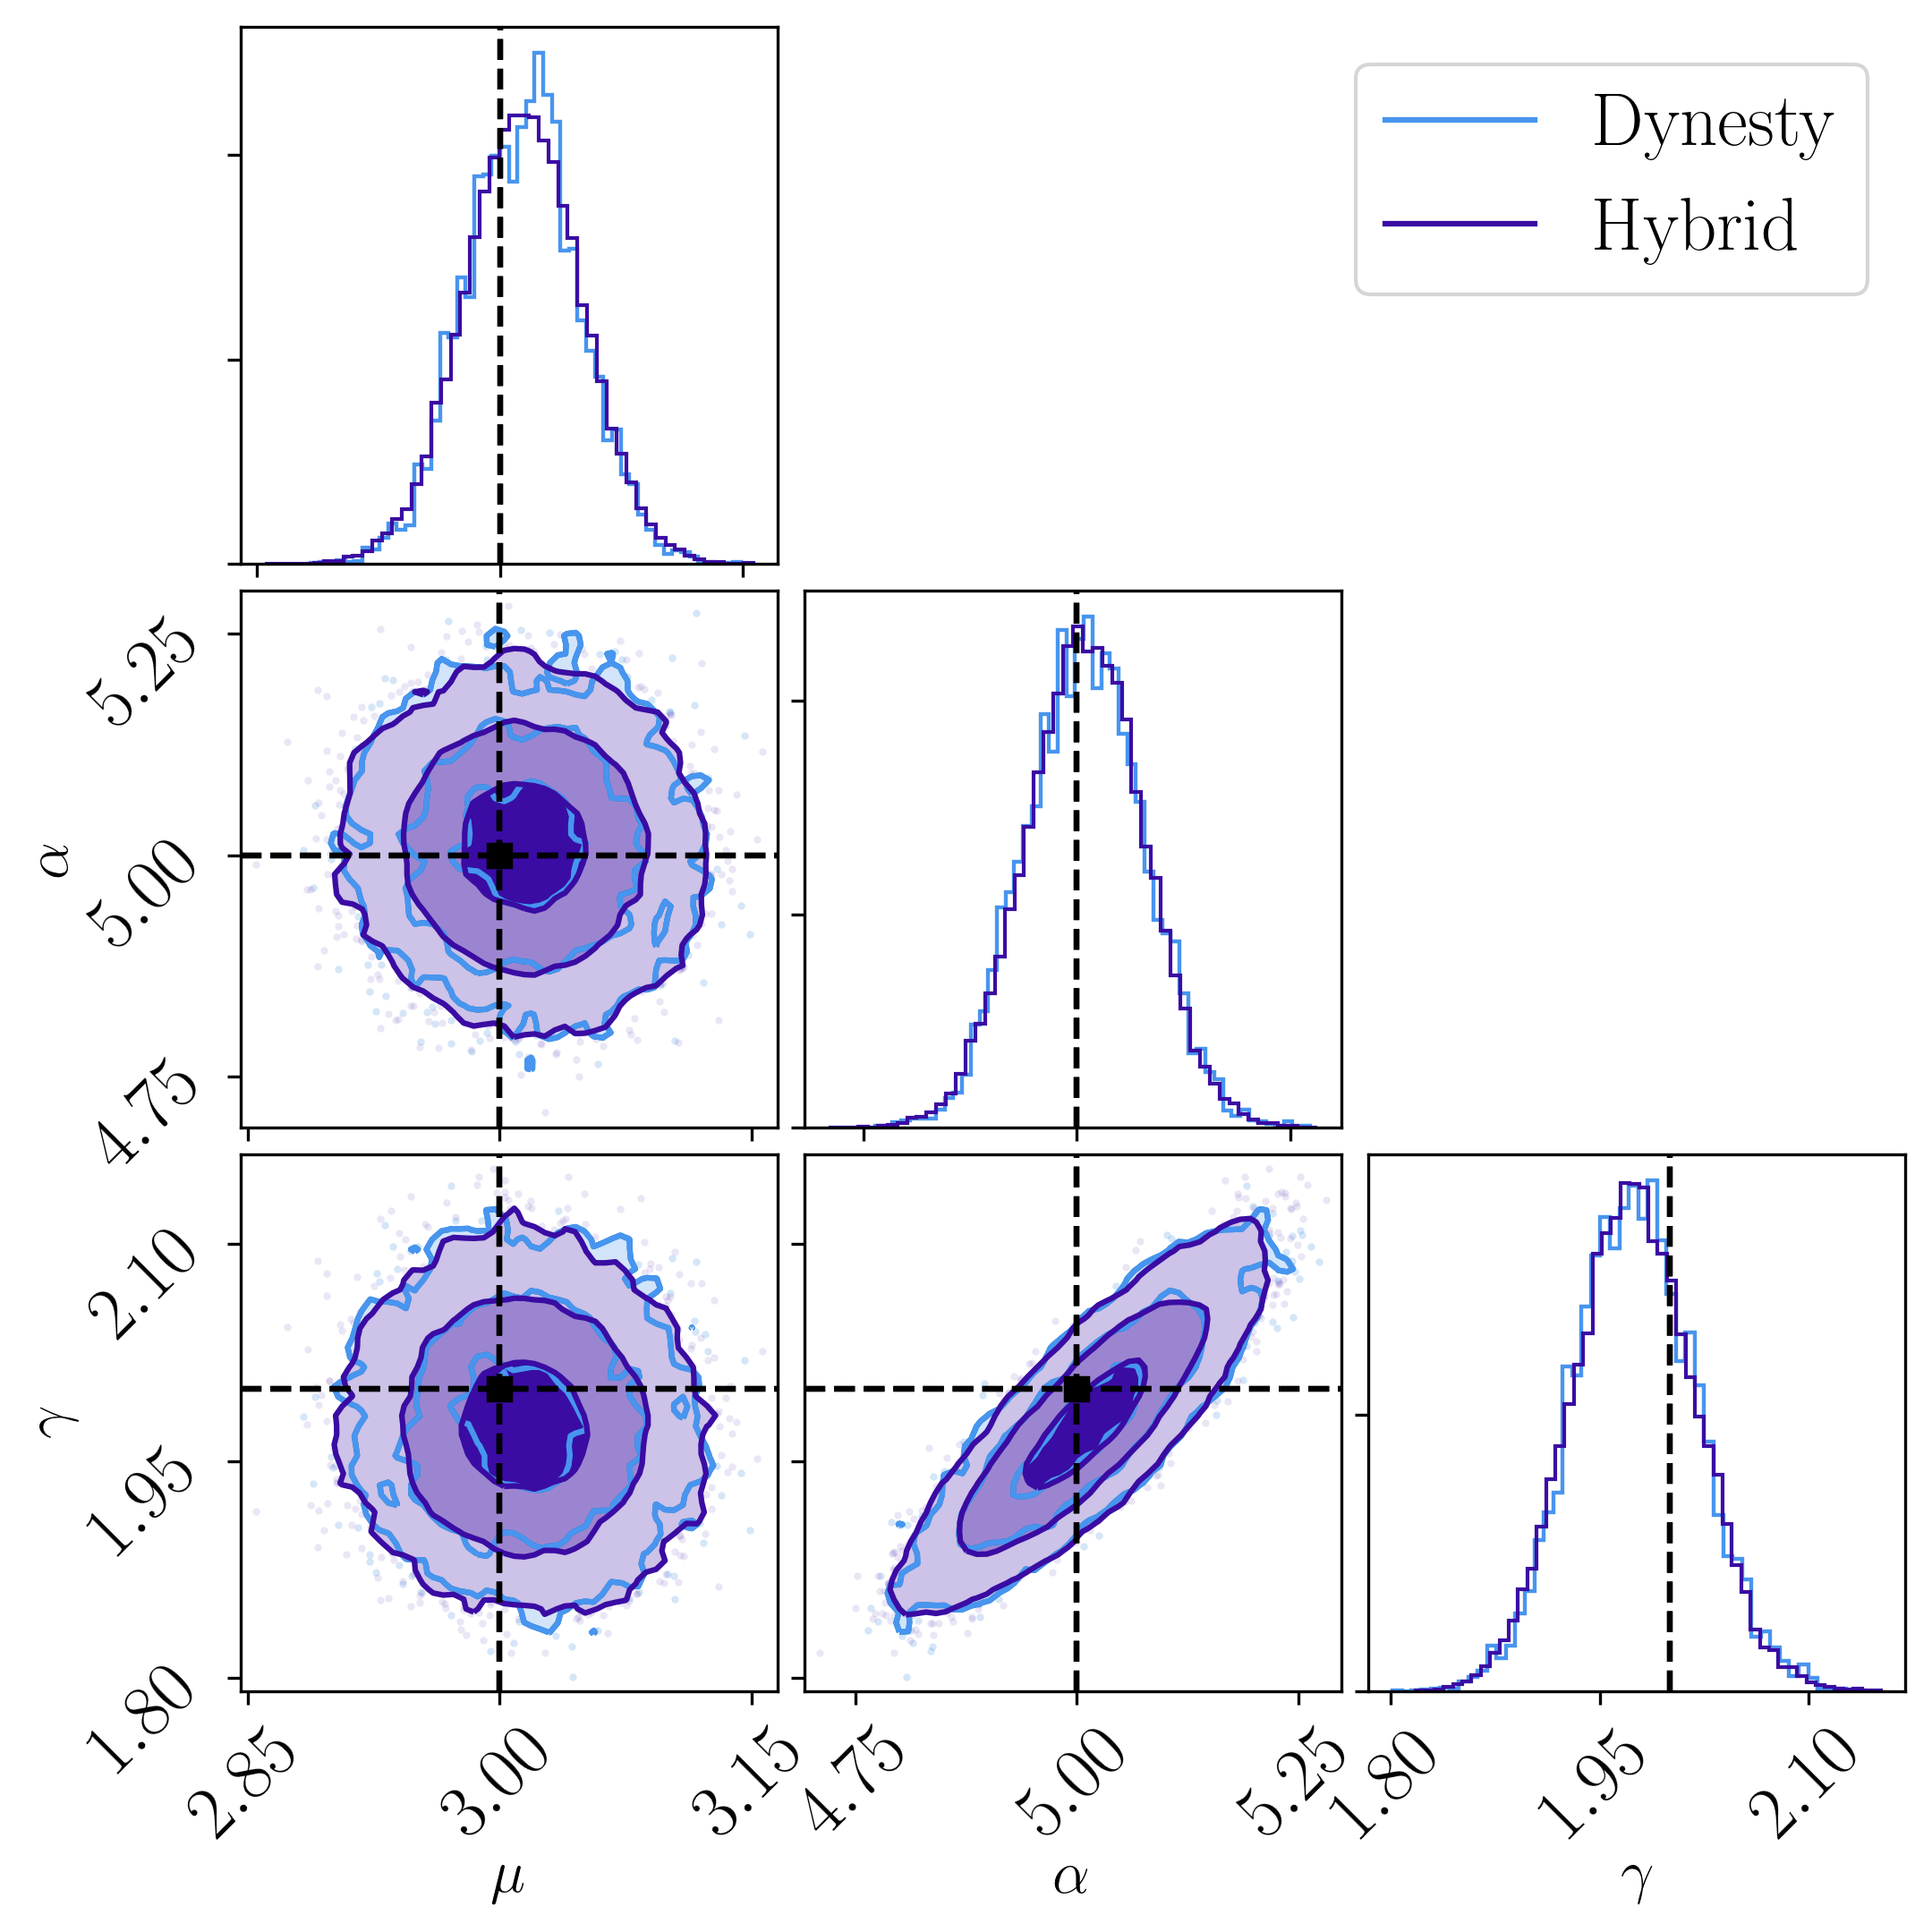

In [6]:
## Combined Corner plot of dynesty-only, hybrid results
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = bilby.core.result.plot_multiple(
        [result_hybrid_nest_only, result_hybrid_pt],
        labels=["Dynesty", "Hybrid"],
        colours=[COMP_COLOR, HYBRID_COLOR],
        titles=False,
        truth_color="black",
        parameters=dict(
            mu=mu_true,
            alpha=alpha_true,
            beta=beta_true
        ),
        corner_labels=[r"$\mu$", r"$\alpha$", r"$\gamma$"],
        quantiles = None
    )

axes = fig.get_axes()
axes[2].legend(
    [ mpl.lines.Line2D([], [], color=COMP_COLOR), mpl.lines.Line2D([], [], color=HYBRID_COLOR) ],
    [ "Dynesty", "Hybrid" ]
)

fig.savefig("./figures/toy-model_wellspecified_comparison.pdf", bbox_inches="tight")